# eXtreme Multi-label Ranking (XMR) Problem and PECOS

Prediction for Enormous and Correlated Output Spaces (PECOS) is a versatile and modular machine learning framework for solving prediction problems with very large outputs spaces. For a given input instance, we apply PECOS to the eXtreme Multilabel Ranking (XMR) problem to find and rank the most relevant items from an enormous but fixed and finite output space.

<div> <br/><img src="imgs/pecos_xmr_framework.png" width="80%"/> </div>

As shown in the above figure, to address the XMR problem, PECOS conceptually consists of three stages, including semantic label indexing, machine-learned matching, and ranking. For more details about XMR problem and model formulation, please refer to presentations in the PECOS Day. In this part of the tutorial, we will use XR-Linear as an example to demonstrate how to use PECOS to tackle real-world problems and understrand the model architecture in PECOS.

## Experimental Dataset

`eurlex-4k`, `wiki10-31k`, `amazoncat-13k`, `amazon-670k`, `wiki-500k`, and `amazon-3m` are available.

In [1]:
DATASET = "wiki10-31k"
! wget -nv -nc https://archive.org/download/pecos-dataset/xmc-base/{DATASET}.tar.gz
! tar --skip-old-files -zxf {DATASET}.tar.gz 
! find xmc-base/{DATASET}/*

2022-07-14 08:54:02 URL:https://ia802308.us.archive.org/21/items/pecos-dataset/xmc-base/wiki10-31k.tar.gz [162277861/162277861] -> "wiki10-31k.tar.gz" [1]
xmc-base/wiki10-31k/output-items.txt
xmc-base/wiki10-31k/tfidf-attnxml
xmc-base/wiki10-31k/tfidf-attnxml/X.trn.npz
xmc-base/wiki10-31k/tfidf-attnxml/X.tst.npz
xmc-base/wiki10-31k/X.trn.txt
xmc-base/wiki10-31k/X.tst.txt
xmc-base/wiki10-31k/Y.trn.npz
xmc-base/wiki10-31k/Y.trn.txt
xmc-base/wiki10-31k/Y.tst.npz
xmc-base/wiki10-31k/Y.tst.txt


### Analyze Sparse Features and Label Space

In [2]:
import numpy as np
import scipy.sparse as smat
import matplotlib.pyplot as plt
X_trn = smat.load_npz(f"xmc-base/{DATASET}/tfidf-attnxml/X.trn.npz")
Y_trn = smat.load_npz(f"xmc-base/{DATASET}/Y.trn.npz")

In [3]:
"{} instances with {} features.".format(*X_trn.shape)

'14146 instances with 101938 features.'

In [4]:
"Overall Sparsity: {:.2f}%".format(100 * (1 - X_trn.nnz / (X_trn.shape[0] * X_trn.shape[1])))

'Overall Sparsity: 99.34%'

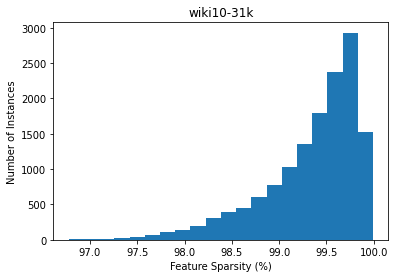

In [5]:
counts, bins = np.histogram(100 - 100 * X_trn.getnnz(1) / X_trn.shape[1], bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.title(DATASET);
plt.xlabel("Feature Sparsity (%)");
plt.ylabel("Number of Instances");

### Extremely large label space

In [6]:
"{} instances with {} labels.".format(*Y_trn.shape)

'14146 instances with 30938 labels.'

In [7]:
"Overall Sparsity: {:.2f}%".format(100 * (1 - Y_trn.nnz / (Y_trn.shape[0] * Y_trn.shape[1])))

'Overall Sparsity: 99.94%'

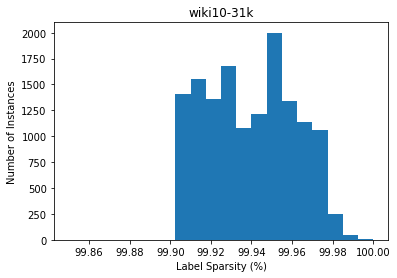

In [8]:
counts, bins = np.histogram(100 - 100 * Y_trn.getnnz(1) / Y_trn.shape[1], bins=20, range=(99.85, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title(DATASET);
plt.xlabel("Label Sparsity (%)");
plt.ylabel("Number of Instances");

## Numerical Feature and Label Format in PECOS

In PECOS, numerical features of instances can be in either a [dense NumPy matrix](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) or a [Compressed Sparse Row (CSR) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) of shape `(nr_inst, nr_feat)`, where `nr_inst` and `nr_feat` are numbers of instances and features. Similary, labels of instances can be also presented as a dense or a sparse matrix of shape `(nr_inst, nr_labels)`, where `nr_labels` is the number of labels in the XMR problem. Note that for the sparse format, training labels should be a [Compressed Sparse Column (CSC) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)   while testing labels should be a CSR matrix for the purpose of computational efficiency. For convenience, PECOS also provides APIs for loading features and labels from binary files in arbitary formats.

In addition to numerical features, PECOS also supports handling text data with transformer. Please refer to [Part 2](Part%202%20-%20Text%20Processing.ipynb) in this tutorial for more details about text processing in PECOS.

In [9]:
import numpy as np
from pecos.xmc.xlinear.model import XLinearModel

DATASET = "wiki10-31k"

X_trn = XLinearModel.load_feature_matrix("xmc-base/{}/tfidf-attnxml/X.trn.npz".format(DATASET))
Y_trn = XLinearModel.load_label_matrix("xmc-base/{}/Y.trn.npz".format(DATASET), for_training=True)

X_tst = XLinearModel.load_feature_matrix("xmc-base/{}/tfidf-attnxml/X.tst.npz".format(DATASET))
Y_tst = XLinearModel.load_label_matrix("xmc-base/{}/Y.tst.npz".format(DATASET), for_training=False)

print(f"Training features X_trn is a {X_trn.getformat()} matrix of shape {X_trn.shape}.")
print(f"Training labels Y_trn is a {Y_trn.getformat()} matrix of shape {Y_trn.shape}.")
print(f"Testing features X_tst is a {X_tst.getformat()} matrix of shape {X_tst.shape}.")
print(f"Testing labels Y_tst is a {Y_tst.getformat()} matrix of shape {Y_tst.shape}.")

Training features X_trn is a csr matrix of shape (14146, 101938).
Training labels Y_trn is a csc matrix of shape (14146, 30938).
Testing features X_tst is a csr matrix of shape (6616, 101938).
Testing labels Y_tst is a csr matrix of shape (6616, 30938).


## Hands-on Example: XMR with XR-Linear

XR-LINEAR is a recursive linear machine learned realization of our PECOS framework. As shown in the below figure, XR-Linear treats machine-learned matching as a smaller XMR problem, thereby recursively apply the three-stage framework of PECOS to address the problem.

<div><br/>
<img src="imgs/pecos_matcher_ranker.png" width="60%"/>
</div>

### Semantic Label Indexing and Cluster Chain in XR-Linear

The first step of training an XR-Linear model is to conduct semantic label indexing and establish the *hierarchial label tree* for resursive training the XR-Linear model and its inference. 

PECOS supports any method for semantic label indexing. In the PECOS library, as a build-in method, we provide Label Representation via Positive Instance Feature Aggregation (PIFA) for semantic label indexing with only the need of positive instances and their features in training data. PECOS can also consider additional label features `Z` of shape `(nr_labels, nr_label_feat)` in either dense or sparse matrix format, where `nr_label_feat` is the number of label features. These representations and features for each label are concatenated or combined as label embedding in `LabelEmbeddingFactory` in PECOS.

To conduct semantic label indexing, PECOS learns an indexer based on label embedding. PECOS currently supports to use the Hierarchical K-Means for semantic label indexing with a hyper-parameter `nr_splits` (the number of clusters in each layer, or `B` in [our report](https://arxiv.org/pdf/2010.05878.pdf)), which decides the depth `D` of the hierarchical label tree. 

In [10]:
from pecos.xmc import Indexer, LabelEmbeddingFactory

label_feat = LabelEmbeddingFactory.create(Y_trn, X_trn, method="pifa")
# label_feat = LabelEmbeddingFactory.create(Y_trn, X_trn, Z, method="pifa_lf_concat") # for using label features Z

cluster_chain = Indexer.gen(label_feat, nr_splits=8, indexer_type="hierarchicalkmeans")

print(f"{len(cluster_chain)} layers in the trained hierarchical label tree.")

4 layers in the trained hierarchical label tree.


### Training XR-Linear Negative Sampling and Sparsification

Negative sampling plays an important role in solving the XMR problem. PECOS currently provides two negative sampling schemes, including Teacher Forcing Negatives (TFN) and Matcher Aware Negatives (MAN). Please refer to [our report](https://arxiv.org/pdf/2010.05878.pdf)) and presentations in the [PECOS Day](https://w.amazon.com/bin/view/Search/MIDAS/Projects/PECOS/PecosDay/) for more details about negative sampling schemes.

To reduce model sizes and improve efficiency, PECOS conduct model sparsification with a hyper-parameter `threshold`. The model weights with absolute values smaller than the threshold will be discarded.

In [11]:
import time
start_time = time.time()

# For negative_sampling_scheme in model training, "man" and tfn+man" are also available.
xlm = XLinearModel.train(X_trn, Y_trn, C=cluster_chain, threshold=0.1, negative_sampling_scheme="tfn")

training_time = time.time() - start_time
print(f"Training time: {training_time:.4f} seconds.")

Training time: 40.9793 seconds.


PECOS supports serializing and loading the trained model into binary on disk with convenient interfaces. Note that model loading with `is_predict_only=True` could lead to faster prediction speed by disabling the flexibility of model modification.

In [12]:
xlm.save("{}.xlm.model".format(DATASET))
xlm = XLinearModel.load("{}.xlm.model".format(DATASET), is_predict_only=False)

### Prediction and Evaluation

As a tree model, the inference method significantly affects the prediction efficiency of XR-Linear in PECOS. As illustrated in the following figure, the prediction process in PECOS employs a beam search with a hyper-parameter `beam_size`. The other hyper-parameter `only_topk` also needs to be decided to limit the predicted most relevant labels for each instance. The `predict` function of the trained model will result in a CSR matrix of shape `(nr_inst, nr_labels)` and exactly `only_topk` non-zero columns for each row (or instance).

<div>
<br/><img src="imgs/pecos_beam_search.png" width="50%"/>
</div>

Y_pred is a csr matrix of shape (6616, 30938) and 66160 non-zero elements.


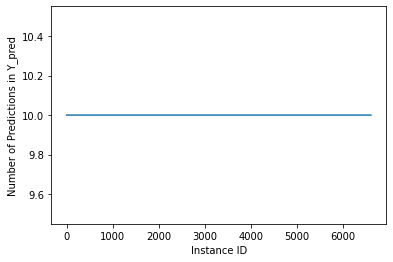

In [13]:
Y_pred = xlm.predict(X_tst, beam_size=10, only_topk=10)

print(f"Y_pred is a {Y_pred.getformat()} matrix of shape {Y_pred.shape} and {Y_pred.nnz} non-zero elements.")

import matplotlib.pyplot as plt
plt.plot(range(Y_pred.shape[0]), Y_pred.getnnz(1))
plt.xlabel("Instance ID");
plt.ylabel("Number of Predictions in Y_pred");

For evaluation, we evaluate the trained model with conventional ranking metrics, including Precision@K and Recall@K. PECOS also provides the evaluation interface for predicted sparse matrices.

In [14]:
from pecos.utils import smat_util
metrics = smat_util.Metrics.generate(Y_tst, Y_pred, topk=10)
print(metrics)

prec   = 84.07 78.17 72.68 67.79 63.79 60.06 56.63 53.51 50.83 48.33
recall = 4.97 9.16 12.68 15.60 18.25 20.49 22.40 24.05 25.60 26.95


###  Dive Deep in Cluster Chain

Specifically, PECOS trains a *cluster_chain* of `D` matching matrices `C[d]`, where `C[d]` is a CSC matrix of shape `(L[d], K[d])`; `L[d]` and `K[d]` are the numbers of labels and clusters in the layer `d`. Note that the clusters of a layer would be the labels of the next layer. The labels of the last layer `L[D - 1]` would be the labels of the overall XMR problem `nr_labels`.

In [15]:
print(f"{len(cluster_chain)} layers in the trained hierarchical label tree with C[d] as:")
for d, C in enumerate(cluster_chain):
    print(f"cluster_chain[{d}] is a {C.getformat()} matrix of shape {C.shape}")

4 layers in the trained hierarchical label tree with C[d] as:
cluster_chain[0] is a csc matrix of shape (8, 1)
cluster_chain[1] is a csc matrix of shape (64, 8)
cluster_chain[2] is a csc matrix of shape (512, 64)
cluster_chain[3] is a csc matrix of shape (30938, 512)


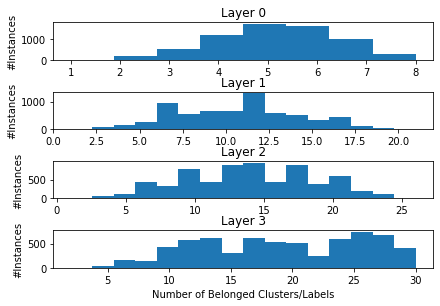

In [16]:
import matplotlib.pyplot as plt
from pecos.core import clib
from pecos.utils import smat_util

fig, axes = plt.subplots(nrows=len(cluster_chain), ncols=1)
fig.tight_layout()

cur_Y = Y_tst

counts, bins = np.histogram(cur_Y.getnnz(1), bins=16)    
ax = plt.subplot(len(cluster_chain), 1, len(cluster_chain))
ax.hist(bins[:-1], bins, weights=counts)
ax.set_title("Layer {}".format(len(cluster_chain) - 1))
plt.ylabel("#Instances")

for d in range(len(cluster_chain) - 1, 0, -1):
    cur_Y = smat_util.binarized(clib.sparse_matmul(cur_Y, cluster_chain[d]))
    counts, bins = np.histogram(cur_Y.getnnz(1), bins=min(16, cluster_chain[d].shape[1]))    
    ax = plt.subplot(len(cluster_chain), 1, d)
    ax.hist(bins[:-1], bins, weights=counts)
    ax.set_title("Layer {}".format(d - 1))
    plt.ylabel("#Instances")
    
    
plt.subplot(len(cluster_chain), 1, len(cluster_chain))
plt.xlabel("Number of Belonged Clusters/Labels");

### Dive Deep in Model Weights

Model weights in an XR-Linear model are also accessible as `model_chain` for analysis and computations. For the i-th layer in the hierarchy, the model weights of matchers/rankers are available as a CSC matrix of shape `(nr_feat + 1, L[i])`, which concatenates weights for features and the bias term. 

model_chain[0].W is a csc matrix of shape (101939, 8)
model_chain[1].W is a csc matrix of shape (101939, 64)
model_chain[2].W is a csc matrix of shape (101939, 512)
model_chain[3].W is a csc matrix of shape (101939, 30938)


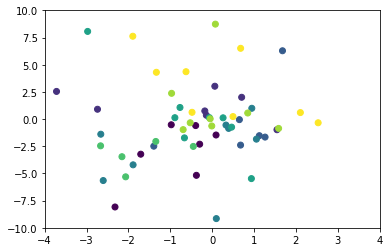

In [17]:
for d, m in enumerate(xlm.model.model_chain):
    print("model_chain[{}].W is a {} matrix of shape {}".format(d, m.W.getformat(), m.W.shape))

layer_d = 1
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=0)
Wt = svd.fit_transform(xlm.model.model_chain[layer_d].W.transpose())

import numpy as np
color = cluster_chain[layer_d].tocsr() * np.arange(cluster_chain[layer_d].shape[1])

import matplotlib.pyplot as plt
plt.scatter(Wt[:, 0], Wt[:, 1], c=color)
plt.xlim(-4, 4);
plt.ylim(-10, 10);

### PECOS and One-versus-All (OVA) Model

PECOS also supports to train an OVA model without leveraing clustering hierarchy if needed.

**Training OVA models is time-consuming, we suggest to try it offline after the tutorial.**

In [18]:
import time
start_time = time.time()

xlm_ova = XLinearModel.train(X_trn, Y_trn, C=None, negative_sampling_scheme="tfn") 

training_time_ova = time.time() - start_time
print("Training time for the OVA model: {:.4f} seconds.".format(training_time_ova))

print("XR-Linear is {:.2f} times faster than the OVA model".format(training_time_ova / training_time))

Training time for the OVA model: 1047.3194 seconds.
XR-Linear is 25.56 times faster than the OVA model


## Customized Parameters and Advanced Training Options

PECOS also supports using customized parameters and several advanced training options, such as different solvers and cost-sensitive learning.

### Customized Parameters

The parameters for either of indexing, training, and inference can be easily customized by feeding a dictionary into the corresponding parameter class and its constructor:

* Semantic Indexing (Hierarchical K-Means): `HierarchicalKMeans.TrainParams.from_dict(dict)`
* Training: `XLinearModel.TrainParams.from_dict(dict)`
* Inference: `XLinearModel.PredParams.from_dict(dict)`

Although most of the parameters can be also passed by `kwargs` of Python methods, **we encourage to use the dictionary to designate the parameters because it is easier to manage, modularize, and store parameters in certain formats like JSON.**

For XR-Linear models, the default values and skeleton of the parameters can be revealed and generated by the following command:

In [19]:
! python3 -m pecos.xmc.xlinear.train --generate-params-skeleton

{
 "train_params": {
  "__meta__": {
   "class_fullname": "pecos.xmc.xlinear.model###XLinearModel.TrainParams"
  },
  "mode": "full-model",
  "ranker_level": 1,
  "nr_splits": 16,
  "min_codes": null,
  "shallow": false,
  "rel_mode": "disable",
  "rel_norm": "no-norm",
  "hlm_args": {
   "__meta__": {
    "class_fullname": "pecos.xmc.base###HierarchicalMLModel.TrainParams"
   },
   "neg_mining_chain": "tfn",
   "model_chain": {
    "__meta__": {
     "class_fullname": "pecos.xmc.base###MLModel.TrainParams"
    },
    "threshold": 0.1,
    "max_nonzeros_per_label": null,
    "solver_type": "L2R_L2LOSS_SVC_DUAL",
    "Cp": 1.0,
    "Cn": 1.0,
    "max_iter": 100,
    "eps": 0.1,
    "bias": 1.0,
    "threads": -1,
    "verbose": 0,
    "newton_eps": 0.01
   }
  }
 },
 "pred_params": {
  "__meta__": {
   "class_fullname": "pecos.xmc.xlinear.model###XLinearModel.PredParams"
  },
  "hlm_args": {
   "__meta__": {
    "class_fullname": "pecos.xmc.base###HierarchicalMLModel.PredParams"
   },


### Training Parameters for Hierarchial Models in XR-Linear

Hierarchical models could have different parameters over layers. To have customized parameters for the hierarchical model, `hlm_args` needs to be designated in the parameter dictionary. The values of `model_chain` and `neg_mining_chain` in `hlm_args` can be **a single dictionary** of general parameters for all layers or **a list of dictinoaries** for specific parameters of individual layers.

#### General Parameters for All Layers

```
train_params_l1 = XLinearModel.TrainParams.from_dict(
    {
        ...
        "hlm_args": {
            ...
            "neg_mining_chain": "tfn", # Negative sampling scheme for all layers
            "model_chain":{...},       # Parameters for all layers
        }
        ...
    })
```

#### Specific Parameters of Individual Layers

```
train_params_l1 = XLinearModel.TrainParams.from_dict(
    {
        ...
        "hlm_args": {
            ...
            "neg_mining_chain": [
                "tfn",      # Negative sampling scheme for layer-0
                "tfn",      # Negative sampling scheme for layer-1
                "tfn+man",  # Negative sampling scheme for layer-2
                ...
            ],
            "model_chain": [
                {...}, # Parameters for layer-0
                {...}, # Parameters for layer-1
                {...}, # Parameters for layer-2
                ...
            ],
        }
        ...
    })
```

### Variety of Solvers

The solver for optimization can be adjusted by the argument `solver_type` in the `train` function. PECOS currently provides the following solvers for training each matcher/ranker:

* "L2R_L2LOSS_SVC_DUAL" (default): L2-regularized L2-loss Dual SVM
* "L2R_L1LOSS_SVC_DUAL": : L2-regularized L1-loss Dual SVM
* "L2R_LR_DUAL": L2-reguarlized Logistic Regression

In [20]:
xlm_l1_kwargs = XLinearModel.train(
    X_trn, Y_trn,
    C=cluster_chain,
    threshold=0.1,
    negative_sampling_scheme="tfn",
    solver_type="L2R_L1LOSS_SVC_DUAL")

In [21]:
train_params_l1 = XLinearModel.TrainParams.from_dict(
    {
        "hlm_args": {
            "threshold": 0.1,
            "neg_mining_chain": "tfn",
            "model_chain":{
                "solver_type": "L2R_L1LOSS_SVC_DUAL",
            },
        }
    }
)

xlm_l1_dict = XLinearModel.train(
    X_trn, Y_trn,
    C=cluster_chain,
    train_params=train_params_l1)

In [22]:
Y_pred_l1_kwargs = xlm_l1_kwargs.predict(X_tst, beam_size=10, only_topk=10)
Y_pred_l1_dict = xlm_l1_dict.predict(X_tst, beam_size=10, only_topk=10)
metrics_l1_kwargs = smat_util.Metrics.generate(Y_tst, Y_pred_l1_kwargs, topk=10)
metrics_l1_dict = smat_util.Metrics.generate(Y_tst, Y_pred_l1_dict, topk=10)

print("Evaluation Metrics with L2R_L1LOSS_SVC_DUAL (by method kwargs)")
print(metrics_l1_kwargs)

print("\nEvaluation Metrics with L2R_L1LOSS_SVC_DUAL (by dictionary)")
print(metrics_l1_dict)

Evaluation Metrics with L2R_L1LOSS_SVC_DUAL (by method kwargs)
prec   = 83.43 77.66 72.47 67.67 63.73 60.18 56.90 54.04 51.45 49.04
recall = 4.93 9.11 12.62 15.59 18.19 20.51 22.49 24.28 25.92 27.36

Evaluation Metrics with L2R_L1LOSS_SVC_DUAL (by dictionary)
prec   = 83.43 77.66 72.47 67.67 63.73 60.18 56.90 54.04 51.45 49.04
recall = 4.93 9.11 12.62 15.59 18.19 20.51 22.49 24.28 25.92 27.36


### Cost-sensitive Learning

PECOS supports to adjust the cost of each training instance. To enable cost-sensitive learning, we need to provide a **relevance matrix** `R_trn` with the same shape to the label matrix `Y_trn` for the argument `R`. When `R` is `None` (default), cost-sensitive learning is disable. 

Since PECOS models are usually hierarhical, costs for upper layers also need to be decided as the cost-sensitive learning mode by the argument `rel_mode`. Currently, PECOS supports the following cost-sensitive learning modes:

* `"disable"` (default): The cost-sensitive learning is disable.
* `"induce"`: Induce the costs into upper layers by the clustering chain.
* `"ranker-only"`: Only apply cost-sensitive learning to the model in the last ranker layer without induction.


In [23]:
# An exmaple of using training label frequency scores as costs. 
import copy
from sklearn.preprocessing import normalize

R_trn = copy.deepcopy(Y_trn)

# Training parameters for cost-sensitive learning.
train_params_cost = XLinearModel.TrainParams.from_dict(
    {
        "rel_mode": "induce",
        "rel_norm": "l1",
        "hlm_args": {
            "neg_mining_chain": "tfn",
            "model_chain":
                [
                    {
                        "threshold": 0.1,
                        "Cp": 1.0,
                        "Cn": 1.0,
                    },
                    {
                        "threshold": 0.1,
                        "Cp": 8.0,
                        "Cn": 1.0,
                    },
                    {
                        "threshold": 0.1,
                        "Cp": 4.0,
                        "Cn": 1.0,
                    },
                    {
                        "threshold": 0.1,
                        "Cp": 4.0,
                        "Cn": 1.0,
                    },
                ],
        }
    })
        
# Cost-sensitive learning.
xlm_cost = XLinearModel.train(
    X_trn, Y_trn,
    C=cluster_chain,
    R=R_trn,
    train_params=train_params_cost)

In [24]:
Y_pred_cost = xlm_cost.predict(X_tst, beam_size=10, only_topk=10)
metrics_cost = smat_util.Metrics.generate(Y_tst, Y_pred_cost, topk=10)
print("Evaluation Metrics with Cost-sensitive Learning")
print(metrics_cost)
print("\nOriginal Evaluation Metrics")
print(metrics)

Evaluation Metrics with Cost-sensitive Learning
prec   = 85.02 80.58 74.57 69.37 64.79 60.82 57.34 54.29 51.37 48.81
recall = 5.02 9.46 13.02 15.99 18.54 20.74 22.69 24.42 25.92 27.27

Original Evaluation Metrics
prec   = 84.07 78.17 72.68 67.79 63.79 60.06 56.63 53.51 50.83 48.33
recall = 4.97 9.16 12.68 15.60 18.25 20.49 22.40 24.05 25.60 26.95


# Customized PECOS Model

Besides pre-defined models in PECOS, such as XR-Linear, it is also convenient for users to customize PECOS for specific purposes and usage. Specifically, we suggest to establishing a model class to wrap fundamental PECOS functions and tailored operations. As a result, the customized model can be easily constructed and consumed for arbitrary data types and feature extractors. 

## Structure of a Customized PECOS Model

Even though a customized machine learning pipeline can be seperated into several independent scripts, we recommend declaring a customized PECOS model as a **model class** for better re-usability and code maintenance.

A customized PECOS model should at least consist of the following components:

* `preprocessor` or `encoder`: The procedure, which can be a method or a functionable object, pre-processes or encodes an arbitrary input with the designated data format into features. For example, text data and image data can be encoded by BERT and ResNet.
* `train()`: The training method takes a set of training data with a preprocessor, learns a primitive PECOS model, and returns a PECOS-based customized machine learning model. The training function could be a class method to construct the model object with the learned model and essential components after training.
* `model`: A primitive PECOS model taking pre-processed features is capable of deriving the predictions for arbitrary testing data. The model weights should be learned by `train()`. 
* `predict()`: The prediction method takes arbitrary testing data and infers the prediction based on the pre-processor and the learned model.
* `save()`: The saving function serializes the trained model, including model weights and configuration, for further usage.
* `load()`: The loading function reads the serialized model so that the trained model can be loaded and re-used.

<div>
<br/><img src="imgs/illus_customized_model.jpg" width="80%"/>
</div>


In this part of the tutorial, we will use the task of *extreme multi-label text classification* as an example to demonstrate how to **customize a PECOS model that can handle text data with either a conventional bag-of-words (BoW) model or a deep learning model as the text encoder for feature extraction**.


## Example: eXtreme Multi-label Text Classification (XMTC)

The task of extreme multi-label text classification (XMTC) seeks to find relevant labels from an extreme large label collection for a given text input. Many real-world applications can be formulated as XMTC tasks, such as recommendation systems, document tagging, and semantic search. 

In this section, we guide through how to establish a customized PECOS model for XMTC tasks. We will walk through (1) PECOS' built-in BOW model for text preprocessing and vectorizing; (2) how to customize a PECOS model; and (3) 
advanced usage of XR-Transformer based on deep learning.


### Preprocessor: Text Preprocessing and Vectorizing

The preprocessor plays a role of encoding input data into machine readable vector representations. Any encoder that can transform text data into a vector representation can be considered as the preprocessor or encoder of a customized PECOS model for XMTC tasks.

In the PECOS library, we provide [various text vectorizers](https://github.com/amzn/pecos/blob/mainline/pecos/utils/featurization/text/vectorizers.py), such as TF-IDF, hashing, and pretrained transformer, as **built-in preprocessors** to deal with text data. In this tutorial, we will utilize the [n-gram](https://en.wikipedia.org/wiki/N-gram)  [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) model as our preprocessor.

#### Label Space File Format  for Built-in Text Preprocessors

Label space is also essential for text preprocessors, especially for understanding the label space size to create the appropriate label matrix. The label IDs start from zero and can be referred to the line numbers and corresponding text descriptions in the label space file.

In [25]:
! cat "./text2text_demo/output-labels.txt"

Artificial intelligence researchers
Computability theorists
British computer scientists
Machine learning researchers
Turing Award laureates
Deep Learning


#### Data File Format  for Built-in Text Preprocessors

PECOS built-in text preprocessors majorly take the files of text data with labels in a tab-separated values (TSV) format. Each line in the TSV file consists of two elements that represent the comma-separated label IDs and the input text of a data instance. 

In [26]:
! cat ./text2text_demo/training-data.txt

0,1,2	Alan Turing is widely considered to be the father of theoretical computer science and artificial intelligence.
0,2,3	Hinton was co-author of a highly cited paper published in 1986 that popularized the backpropagation algorithm for training multi-layer neural networks.
3,4,5	Hinton received the 2018 Turing Award, together with Yoshua Bengio and Yann LeCun, for their work on artificial intelligence and deep learning.
0,3,5	Yoshua Bengio is a Canadian computer scientist, most noted for his work on artificial neural networks and deep learning.


The data file format also supports to represent the label relevance for cost-sensitive learning by using double colons to separate a label and its relevance.

<p style="text-align: center;"><i>
0::0.1,1::0.2,2::0.8 &lt;TAB&gt; Alan Turing is widely considered to be the father of theoretical computer science and artificial intelligence.</i></p>


#### Training a Text Preprocessor

The preprocessor model `Preprocessor` is defined in `pecos.utils.featurization.text.preprocess`. Given a training text corpus and the configuration dictionary, the class method `Preprocessor.train` will train a corresponding text preprocesssor. Besides, the built-in preprocessors also support serialization with the function `save()` for the re-usability.

With the previously mentioned data and label space file formats, the utility function `Preprocessor.load_data_from_file(input_text_path, output_text_path)` returns a dictionary with three keys:

* `label_matrix`: a `(num_inst, num_labels)` CSR matrix for the labels of each instance.
* `label_relevance`: `None` or a `(num_inst, num_labels)` CSR matrix for the relevance of each label in cost-sensitive learning if available.
* `corpus`: a list of string as the text corpus in the input_text_path.

The configuration settings of text preprocessor including the preprocessor type and hyper-parameters should be defined in a dictionary. Specifially, the key `type` defines the preprocessor choice while the key `kwargs` represents the hyper-parameters. In this tutorial, we adopt n-gram TFIDF features containing *word unigrams*, *word bigrams*, and *character trigrams*. Note that each of the n-gram feature can have different hyper-parameters, such as `max_feature` and `max_df`. Users need to properly set max_feature (e.g., hundred of thousands or millions) based on the corpus size and downstream tasks.

In [27]:
from pecos.utils.featurization.text.preprocess import Preprocessor

input_text_path = "./text2text_demo/training-data.txt"
output_text_path = "./text2text_demo/output-labels.txt"
model_folder = "./text2text_demo/pecos-text2text-model"

parsed_result = Preprocessor.load_data_from_file(input_text_path, output_text_path) # Read files
corpus = parsed_result["corpus"] # Corpus input text: List of strings

vectorizer_config = {
    "type": "tfidf",
    "kwargs": {
      "base_vect_configs": [
          
        {
          "ngram_range": [1, 1],
          "max_df_ratio": 0.98,
          "analyzer": "word",
        },
        {
          "ngram_range": [2, 2],
          "max_df_ratio": 0.98,
          "analyzer": "word",
        },
        {
          "ngram_range": [3, 3],
          "max_df_ratio": 0.98,
          "analyzer": "char_wb",
        },
      ],
    },
  }

preprocessor = Preprocessor.train(corpus, vectorizer_config)
preprocessor.save(model_folder) 

#### Preprocessing with a Trained Text Preprocessor

The function `predict` of a trained text preprocessor encodes texts in a **text data file** into a CSR matrix of shape `(num_inst, dim)` as numerical vector representations, where `num_inst` is the number of instances in the file; `dim` is the number of feature dimensions.

In [28]:
# Obtaining numerical vectors from text
X = preprocessor.predict(corpus)

print("The file consists of {} instances "
      "with {}-dimensional features "
      "in a {} matrix.\n".format(*X.shape, X.getformat()))

from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X)

for i, ti in enumerate(corpus):
    print("Text {}: {}".format(i, ti))

print("")
for i in range(X.shape[0]):
    for j in range(i):
        print("The cosine similarity is {:.4f} between text {} and text {}.".format(sim[i][j], j, i))

The file consists of 4 instances with 405-dimensional features in a csr matrix.

Text 0: Alan Turing is widely considered to be the father of theoretical computer science and artificial intelligence.
Text 1: Hinton was co-author of a highly cited paper published in 1986 that popularized the backpropagation algorithm for training multi-layer neural networks.
Text 2: Hinton received the 2018 Turing Award, together with Yoshua Bengio and Yann LeCun, for their work on artificial intelligence and deep learning.
Text 3: Yoshua Bengio is a Canadian computer scientist, most noted for his work on artificial neural networks and deep learning.

The cosine similarity is 0.0076 between text 0 and text 1.
The cosine similarity is 0.0325 between text 0 and text 2.
The cosine similarity is 0.0082 between text 1 and text 2.
The cosine similarity is 0.0366 between text 0 and text 3.
The cosine similarity is 0.0267 between text 1 and text 3.
The cosine similarity is 0.0943 between text 2 and text 3.


#### Efficiency of PECOS Built-in TF-IDF Vectorizer

Moreover, the TF-IDF vectorizer in PECOS is implemented in C++ and efficient.

In [29]:
vectorizer_config = {
    "type": "tfidf",
    "kwargs": {
      "base_vect_configs": [ 
        {
          "ngram_range": [1, 2],
          "max_df_ratio": 0.98,
          "analyzer": "word",
        },
      ],
    },
  }

input_text_path = "xmc-base/wiki10-31k/X.trn.txt"
corpus = Preprocessor.load_data_from_file(input_text_path, text_pos=0)["corpus"]

import time
start_time = time.time()
preprocessor = Preprocessor.train(corpus, vectorizer_config)
X = preprocessor.predict(input_text_path)
print(f"PECOS TFIDF time: {time.time() - start_time:.5f}s, result shaepe={X.shape}, nnz={X.nnz}")

PECOS TFIDF time: 27.30768s, result shaepe=(14146, 10858825), nnz=37194670


As a baseline method, we compare with the [Sklearn TFIDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [30]:
start_time = time.time()
preprocessor = Preprocessor.train(
    corpus,
    {"type": "sklearntfidf", "kwargs":{"ngram_range": [1, 2], "max_df": 0.98}},
)
X = preprocessor.predict(corpus)
print(f"Sklearn TFIDF time: {time.time() - start_time:.5f}s, result shaepe={X.shape}, nnz={X.nnz}")

Sklearn TFIDF time: 221.65870s, result shaepe=(14146, 7269690), nnz=33505461


### Customized PECOS Model with TF-IDF Preprocessor


After being powered with text preprocessors, following the [aforementioned illustration](#Structure-of-a-Customized-PECOS-Model), we demonstrate an example of declaring a **customized PECOS model class** based on a TF-IDF preprocessor and a XR-Linear model.

In [31]:
import json
from os import path
import pathlib
from pecos.utils.featurization.text.preprocess import Preprocessor
from pecos.xmc.xlinear.model import XLinearModel
from pecos.xmc import Indexer, LabelEmbeddingFactory
from pecos.utils import smat_util

class CustomPECOS:
    def __init__(self, preprocessor=None, xlinear_model=None, output_items=None):
        self.preprocessor = preprocessor
        self.xlinear_model = xlinear_model
        self.output_items = output_items
        
    @classmethod
    def train(cls, input_text_path, output_text_path):
        """Train a CustomPECOS model
        
        Args: 
            input_text_path (str): Text input file name.            
            output_text_path (str): The file path for output text items.
            vectorizer_config (str): Json_format string for vectorizer config (default None). e.g. {"type": "tfidf", "kwargs": {}}
            
        Returns:
            A CustomPECOS object
        """
        # Obtain X_text, Y
        parsed_result = Preprocessor.load_data_from_file(input_text_path, output_text_path)
        Y = parsed_result["label_matrix"]
        corpus = parsed_result["corpus"]

        # Train TF-IDF vectorizer
        preprocessor = Preprocessor.train(corpus, {"type": "tfidf", "kwargs":{}}) 
        X = preprocessor.predict(corpus)   
        
        # Train a XR-Linear model with TF-IDF features
        label_feat = LabelEmbeddingFactory.create(Y, X, method="pifa")
        cluster_chain = Indexer.gen(label_feat)
        xlinear_model = XLinearModel.train(X, Y, C=cluster_chain)
        
        # Load output items
        with open(output_text_path, "r", encoding="utf-8") as f:
            output_items = [q.strip() for q in f]
        
        return cls(preprocessor, xlinear_model, output_items)
    
    def predict(self, corpus):
        """Predict labels for given inputs
        
        Args:
            corpus (list of strings): input strings.
        Returns:
            csr_matrix: predicted label matrix (num_samples x num_labels)
        """
        X = self.preprocessor.predict(corpus)
        Y_pred = self.xlinear_model.predict(X)
        return smat_util.sorted_csr(Y_pred)

    def save(self, model_folder):
        """Save the CustomPECOS model

        Args:
            model_folder (str): folder name to save
        """
        self.preprocessor.save(f"{model_folder}/preprocessor")
        self.xlinear_model.save(f"{model_folder}/xlinear_model")
        with open(f"{model_folder}/output_items.json", "w", encoding="utf-8") as fp:
            json.dump(self.output_items, fp)

    @classmethod
    def load(cls, model_folder):
        """Load the CustomPECOS model

        Args:
            model_folder (str): folder name to load
        Returns:
            CustomPECOS
        """
        preprocessor = Preprocessor.load(f"{model_folder}/preprocessor")
        xlinear_model = XLinearModel.load(f"{model_folder}/xlinear_model")
        with open(f"{model_folder}/output_items.json", "r", encoding="utf-8") as fin:
            output_items = json.load(fin)
        return cls(preprocessor, xlinear_model, output_items)

### Operating the Customized PECOS Model

With a well-declared model class, the customized PECOS model can be modularized and very convenient to use.

In [32]:
# Declare the path for model serialization and preprocessor configuration.
model_folder = "./text2text_demo/pecos-CustomPECOS-model"

# Train and save the trained model
input_text_path = "./text2text_demo/training-data.txt"
output_text_path = "./text2text_demo/output-labels.txt"
model = CustomPECOS.train(input_text_path, output_text_path)
model.save(model_folder)

# Load the trained model and predict
model = model.load(model_folder)
testing_text_path = "./text2text_demo/testing-data.txt"
Y_pred = model.predict(testing_text_path)

In [33]:
test_texts = Preprocessor.load_data_from_file(testing_text_path, output_text_path)["corpus"]

for i, text in enumerate(test_texts):
    print("Text Input: {}".format(text))
    for j in range(Y_pred.indptr[i], Y_pred.indptr[i + 1]):
        pred_label = model.output_items[Y_pred.indices[j]]
        pred_score = Y_pred.data[j]
        print("Score {:.4f}: {}".format(pred_score, pred_label))

Text Input: In 1989, Yann LeCun et al. applied the standard backpropagation algorithm on neural networks for hand digit recognition.
Score 0.9515: Machine learning researchers
Score 0.8233: Artificial intelligence researchers
Score 0.4659: Deep Learning
Score 0.2779: British computer scientists
Score 0.0569: Turing Award laureates
Score 0.0129: Computability theorists
